<a href="https://colab.research.google.com/github/st-sashou/ai_experimental/blob/master/feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ランダムフォレストによる特徴量の重要度の算出
説明変数を**Axxx～Bxxx**、目的変数を**年収**とする。  
年収に与える各説明変数の影響度を算出することとする。

## アンケートデータの読み込み

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

INPUT_FILE = '/content/drive/My Drive/Colab Notebooks/ST/アンケート重要度/cw_5th_12000_survey.pkl'
df_survey = pd.read_pickle(INPUT_FILE)
df_survey = df_survey.loc[:, ['survey_number', 'question']].set_index('survey_number')
df_survey.head()

,question
survey_number,
P001,月間の労働時間は１６０時間を超えていますか？
P002,あなたの生まれた年を教えてください
P003,あなたの性別を教えてください
P004,あなたの身長を教えてください
P005,あなたの体重を教えてください


In [3]:
INPUT_FILE = '/content/drive/My Drive/Colab Notebooks/ST/アンケート重要度/cw_5th_12000_answer.pkl'
df = pd.read_pickle(INPUT_FILE)
df.head()

,respondent_id,annual_income,A002,A003,A004,A005,A006,A008,A009,A010,...,P001,P002,P003,P004,P005,P006,P007,P008,P009,P010
0,399534,550,False,True,False,False,False,True,True,False,...,True,1976,"""男性""",175,64.0,40,70,0,"""事務""","""係長・主任"""
1,488842,120,True,True,True,False,True,True,True,False,...,True,1980,"""男性""",177,64.4,10,0,0,"""サービス""","""その他専門職・特別職等"""
2,515662,260,False,False,False,True,False,False,False,False,...,True,1983,"""女性""",156,48.0,20,20,0,"""営業・販売""","""係長・主任"""
3,890958,96,True,False,True,False,True,False,True,False,...,True,1974,"""女性""",158,72.6,8,0,0,"""その他""","""その他専門職・特別職等"""
4,1227044,292,True,False,True,False,True,True,True,False,...,True,1986,"""女性""",157,49.0,21,40,0,"""その他""","""一般社員"""


## 事前処理

In [0]:
columns = df.columns
columns = pd.Series(columns[columns.str.startswith('A') | columns.str.startswith('B')].sort_values(ascending=True))

X = df.loc[:, columns].astype('float')
Y = df.loc[:, ['annual_income']]

In [5]:
X.head()

,A002,A003,A004,A005,A006,A008,A009,A010,A011,A013,...,B704,B705,B706,B707,B708,B709,B710,B711,B712,B713
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
Y.head()

,annual_income
0,550
1,120
2,260
3,96
4,292


## ランダムフォレストオブジェクトによる重要度の抽出

### オブジェクトの生成とモデルの適合

In [7]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X, Y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

### 重要度の表示



*   number: アンケート番号
*   importance: 重要度 (0≦importance≦1)
*   question: アンケート文



In [8]:
import numpy as np

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

print("   %-*s %-*s %s" % (8, 'number', 12, 'importance', 'question'))
for f in range(X.shape[1]):
    print("%2d) %-*s %-*f %s" %
            (f + 1, 8, columns[indices[f]], 10, importances[indices[f]], df_survey.at[columns[indices[f]], 'question']))

   number   importance   question
 1) A041     0.001955   思ったことは我慢せず、何でも口にできるほうですか？
 2) A697     0.001766   飲むヨーグルトを飲まないようにしていますか？
 3) A594     0.001764   月に１回以上、シメジを食べていますか？
 4) B711     0.001728   直近１ヶ月間で、嫌みを言ってしまったことがありましたか？
 5) B162     0.001726   年に１回以上、便秘になりますか？
 6) A758     0.001724   週に１回以上、淹れたての緑茶を飲んでいますか？
 7) A814     0.001710   月に１回以上、音楽を聴いて余暇を過ごしますか？
 8) A054     0.001689   朝食にファーストフードを食べないようにしていますか？
 9) A048     0.001686   食事はなるべく野菜から食べるようにしていますか？
10) A439     0.001679   週に１回以上、納豆やヨーグルトなどの発酵食品を食べていますか？
11) B440     0.001666   月に１回以上、頭痛のために、仕事や家事を休んだことがありますか？
12) B180     0.001666   年に１回以上、風邪を引きますか？
13) A089     0.001663   １日に３０分以上、歩いていますか？
14) B114     0.001652   人よりも扁桃腺が腫れやすいですか？
15) A815     0.001649   月に１回以上、ゲームをして余暇を過ごしますか？（スマホ、PC等媒体は問いません）
16) A761     0.001642   牛乳を飲まないようにしていますか？
17) A789     0.001638   週に５回以上、グラス一杯程度のアルコールを飲んでいますか？
18) A301     0.001634   コーヒーフレッシュを使わないようにしていますか？
19) A643     0.001633   月に１回以上、納豆やヨーグルトなどの発酵食品を食べていますか？
20) A801     0.001628   週に１回以上、

### 上位100問までの重要度のグラフ

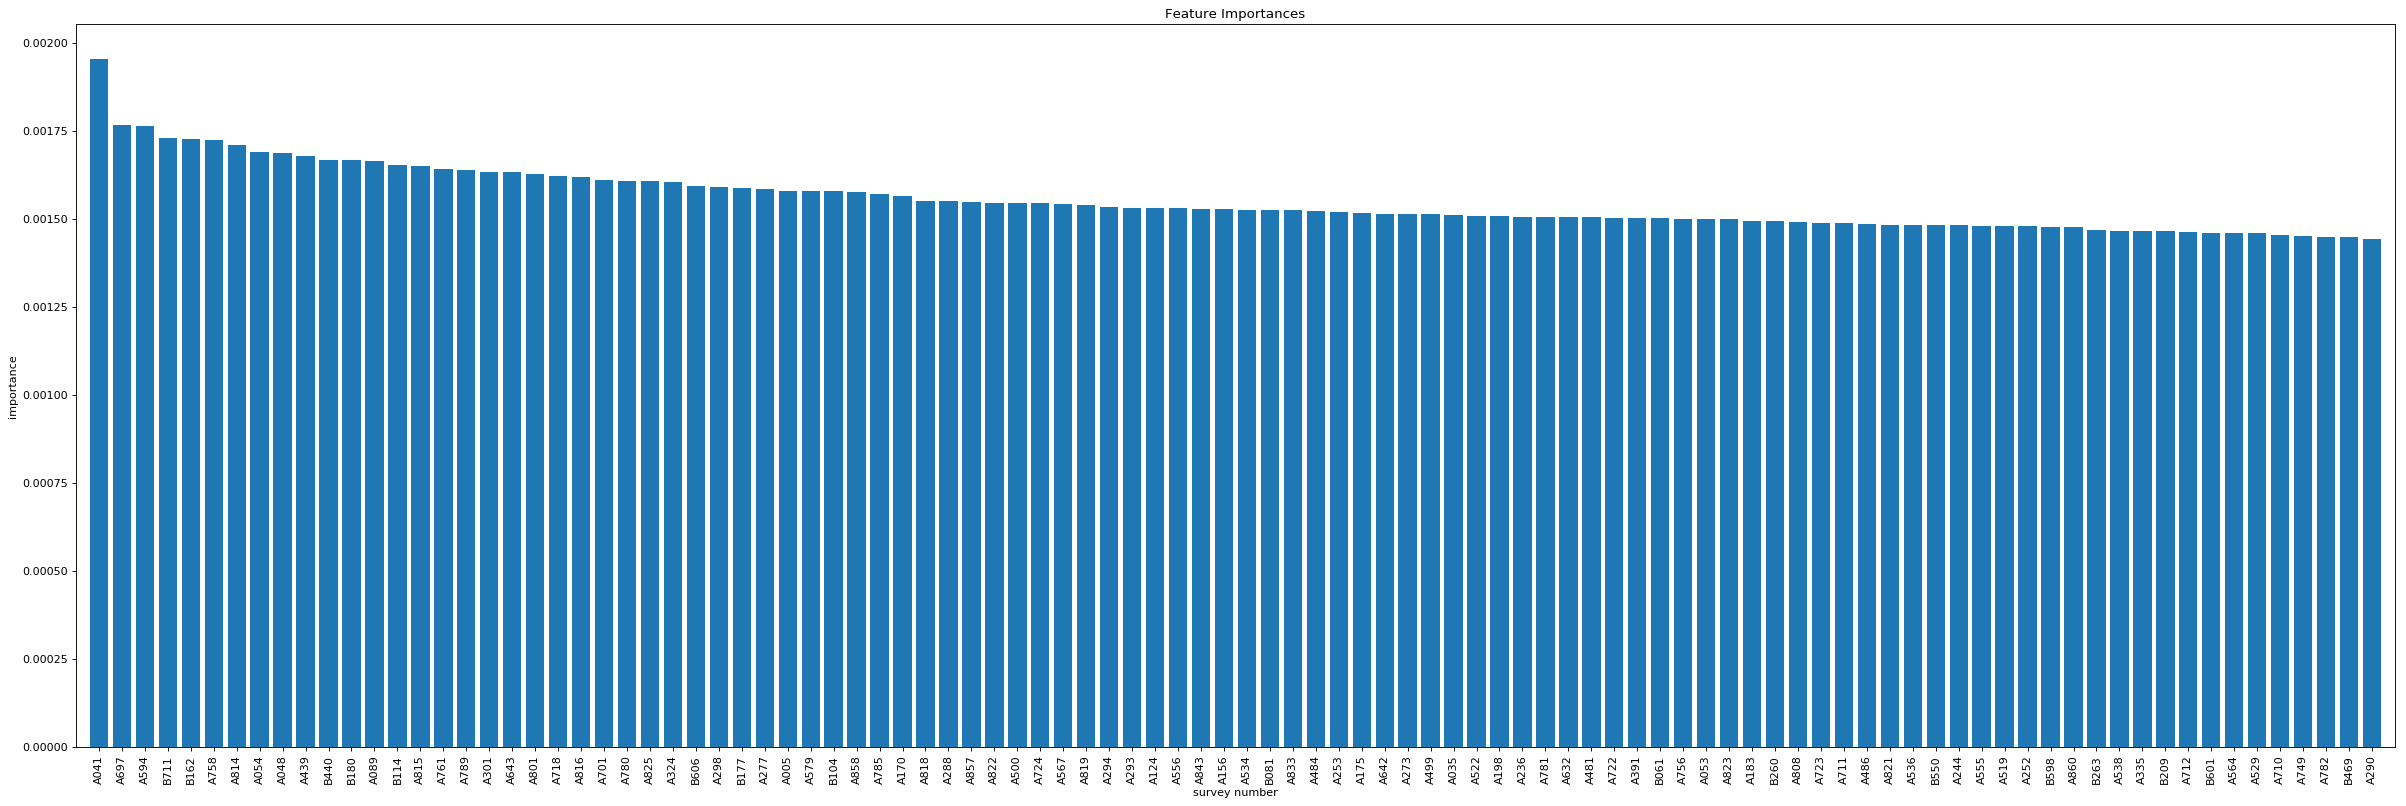

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10), dpi=80)
plt.title('Feature Importances')
plt.bar(range(100), importances[indices[0:100]], align='center')
plt.xticks(range(100), columns[indices[0:100]], rotation=90)
plt.xlim([-1, 100])
plt.tight_layout()
plt.xlabel('survey number')
plt.ylabel('importance')
plt.show()